In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from astropy.modeling.functional_models import Gaussian2D
from astropy.modeling import fitting
import matplotlib.pyplot as plt
import argparse
import warnings
import sys
import sympy as sp
from scipy.stats import pearsonr
from Ellipticity import Ellipse
from astropy.time import Time
import P_Cyg as pc
from glob import glob
paperdir = "C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Figures/Paper_Figures"
sp.init_printing()
fitter = fitting.LevMarLSQFitter()
from matplotlib import rcParams
#rcParams['text.usetex'] = True
rcParams['figure.figsize'] = [10,10]
rcParams['lines.color'] = 'black'
rcParams['font.size'] = 28
rcParams['font.family'] = 'serif'
rcParams['legend.fontsize'] = 14
rcParams['xtick.labelsize']= 20
rcParams['ytick.labelsize']= 20

In [2]:
def ncplot(x,y,z,n=10,alpha=1):
    f = plt.figure(figsize = (5,5))
    ax = f.gca()
    out_obj = ax.contourf(x,y,z,n,cmap='viridis',alpha=alpha)
    #make sure axis are the same proportion
    xrange=x.max()-x.min()
    yrange=y.max()-y.min()
    if yrange < xrange:
        diff=xrange-yrange
        ax.set_ylim(y.min()-diff/2,y.max()+diff/2)
    elif xrange < yrange:
        diff=yrange-xrange
        ax.set_xlim(x.min()-diff/2,x.max()+diff/2)
    ax.set_xlabel(r"Stokes Q",size=20,fontname="Arial")
    ax.set_ylabel(r"Stokes U",size=20,fontname="Arial")
    #out_obj is used for colorbars
    return ax, out_obj

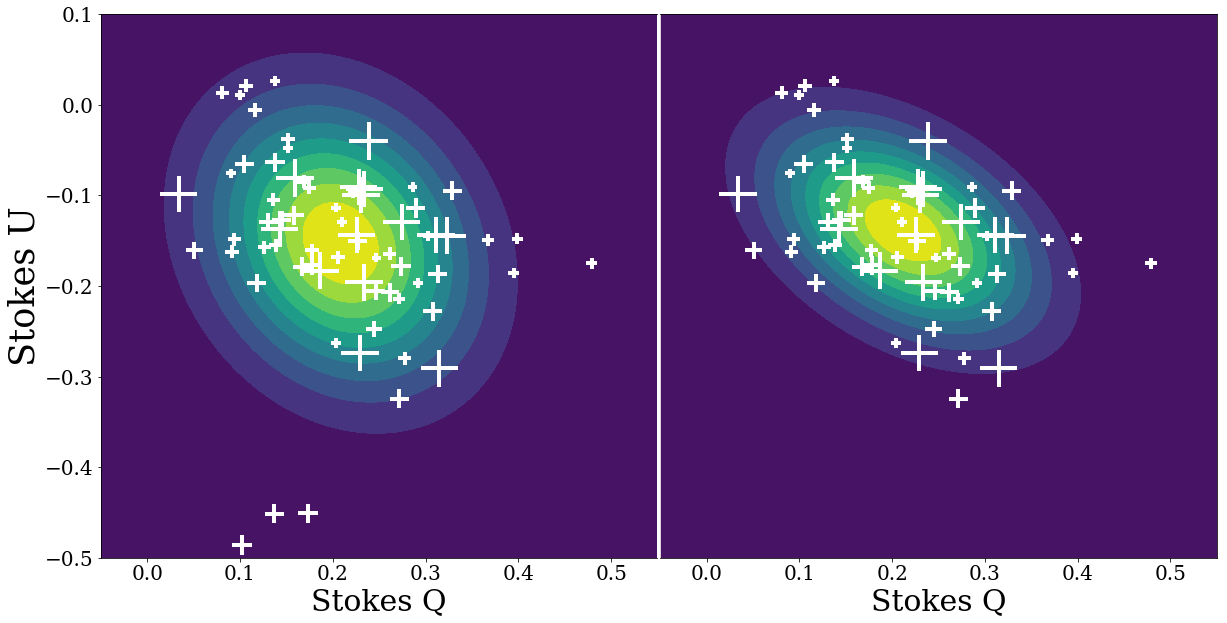

In [3]:
vdf = pd.read_csv("C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Data/KDE/VBandData.txt",delim_whitespace=True)
err = np.sqrt(vdf.SysError**2 + vdf.IntError**2).values
v = Ellipse(q=vdf.Q[vdf.U>-0.4],u=vdf.U[vdf.U>-0.4])
v2 = Ellipse(q=vdf.Q,u=vdf.U)
err2 = np.sqrt(vdf.SysError[vdf.U>-0.4]**2 + vdf.IntError[vdf.U>-0.4]**2).values

fig = plt.figure(figsize=[20,10])
fig.subplots_adjust(wspace=0.05,hspace=0.01)
plt.tight_layout(rect=(0,0,1,1))
ax1 = plt.subplot2grid((10,20),(0,0),colspan=10,rowspan=10)
ax2 = plt.subplot2grid((10,20),(0,10),colspan=10,rowspan=10)

ax1.set_facecolor("#471365")
ax1.spines['right'].set_color("white")
ax1.contourf(v2.X,v2.Y,v2.G,levels=10,cmap=plt.cm.viridis)
ax1.errorbar(v2.q,v2.u,yerr=err,xerr=err,linestyle='none',elinewidth=4, color='white')
ax1.set_ylabel("Stokes U",fontsize=35)
ax1.set_xlabel("Stokes Q",fontsize=30)
ax1.set_ylim(-0.5,0.1)
ax1.set_xlim(0.25-0.3,0.25+0.3)

ax2.set_ylim(-0.5,0.1)
ax2.set_xlim(0.25-0.3,0.25+0.3)
# ax2.set_aspect('equal')
ax2.set_yticks([])
ax2.set_facecolor("#471365")
ax2.spines['left'].set_color("white")
ax2.contourf(v.X,v.Y,v.G,levels=10,cmap=plt.cm.viridis)
#ax2.scatter(v2.q,v2.u,marker='+',s=600, color='white')
ax2.errorbar(v.q,v.u,yerr=err2,xerr=err2,linestyle='none',elinewidth=4, color='white')
ax2.set_xlabel("Stokes Q",fontsize=30)
#ax2.set_ylabel("Stokes U",fontsize=30)
plt.savefig(paperdir+"/test_gauss.png",overwrite=True,dpi=300)
testsig,testL = v.sig,v.L
fulltestsig,fulltestL = v2.sig,v2.L

# P Cyg V-Band Test

Now that we have synthetic V-band data, we can test that instead of the H$\alpha$ data

In [4]:
ccd_dir = 'C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Data/synthetic_filters/VBand_CCD_WithErrors.txt'
ret_dir = 'C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Data/synthetic_filters/VBand_Reticon_WithErrors.txt'
ccd = pd.read_csv(ccd_dir,delim_whitespace=True)
ret = pd.read_csv(ret_dir,delim_whitespace=True)
table = pd.concat([ret,ccd]).reset_index().drop(columns='index')
find_detector = lambda files : [f[4:7]    for f in files]
find_date = lambda files : [f[14:18]+'-'+f[18:20]+'-'+f[20:22]    for f in files]
table["Detector"] = find_detector(table["File/Night"])
table["Date"] = find_date(table["File/Night"])
table["MJD"] = Time(list(table.Date.values),format='fits',location=(43,-89,0)).mjd
table["Error"] = np.sqrt(table.Internal_Error **2 + table.Systematic_Error **2)
table["% Polarization"],table["Position Angle"] = pc.polarization(table.q,table.u)
table["Position Angle Error"] = pc.position_angle_error(table["% Polarization"],table.Error)
t = pd.DataFrame({"Detector":table.Detector, "Date":table.Date, "MJD":table.MJD, "q":table.q, "u":table.u, 
                  "% Polarization": table["% Polarization"], "Error":table.Error, "Position Angle":table["Position Angle"], 
                 "Position Angle Error":table["Position Angle Error"]})

In [5]:
vp = Ellipse(q = t.q, u = t.u)

In [6]:
intrinsic_dir = "C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Data/intrinsic_pols/"
files = glob(intrinsic_dir+"*")
retfiles = [f    for f in files if f[72]=='o']
rfiles = [f    for f in files if f[72]=='r']
bfiles = [f    for f in files if f[72]=='b']
matched = []
for rf in rfiles:
    for bf in bfiles:
        if rf[64:69]==bf[64:69]:
            matched.append([rf,bf])
matched = np.array(matched)
mdfs = [[pd.read_csv(f[0]),pd.read_csv(f[1])]    for f in matched]
mdfs = [pd.concat([p[0],p[1][p[1].Wavelength < 6100]]).sort_values("Wavelength")    for p in mdfs]
rdfs = [pd.read_csv(f)    for f in files if f[72]=='r']
bdfs = [pd.read_csv(f)    for f in files if f[72]=='b']
retdfs = [pd.read_csv(f)     for f in retfiles]
alldfs = retdfs+mdfs
t = [float(f[64:69])    for f in retfiles] + [float(f[0][64:69])    for f in matched]
qs = np.array([np.mean(df.Q[(df.Wavelength > 6700) & (df.Wavelength < 7500)])   for df in alldfs])
us = np.array([np.mean(df.U[(df.Wavelength > 6700) & (df.Wavelength < 7500)])   for df in alldfs])
es = np.array([np.sqrt(np.sum(df.Error[(df.Wavelength > 6700) & (df.Wavelength < 7500)]**2))/
               df.Error[(df.Wavelength > 6700) & (df.Wavelength < 7500)].size    
               for df in alldfs])

In [7]:
vvv = pd.read_csv("C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Data/bigtable.txt")
vip = Ellipse(q=vvv.q1,u=vvv.u1)

0.27639978065968096 0.9822987221519244


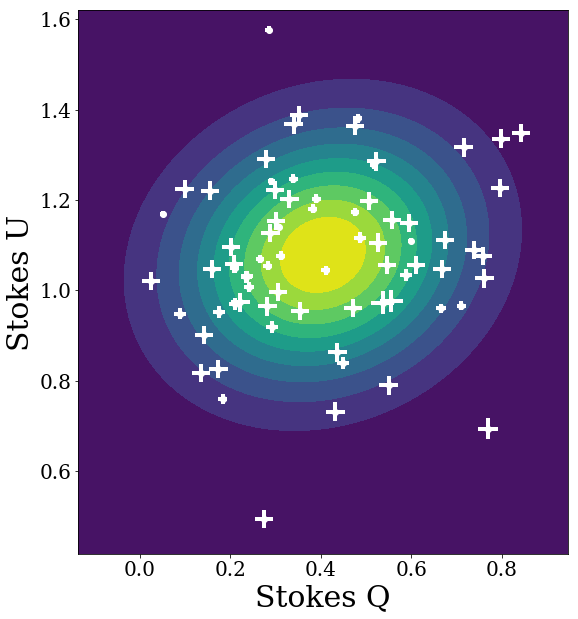

In [8]:
fig,ax = plt.subplots(figsize=[10,10])
ax.set_aspect('equal')
ax.set_facecolor("#471365")
ax.contourf(vip.X,vip.Y,vip.G,levels=10,cmap=plt.cm.viridis)
ax.errorbar(vvv.q1,vvv.u1,yerr=vvv.Error1,xerr=vvv.Error1,linestyle='none',elinewidth=4, color='white',marker='o')
ax.set_ylabel("Stokes U",fontsize=30)
ax.set_xlabel("Stokes Q",fontsize=30)
# ax.set_ylim(-0.6,0.5)
# ax.axvline(0,linestyle='--',color='white',alpha=0.5)
# ax.axhline(0,linestyle='--',color='white',alpha=0.5)
pcygsig,pcygL = vip.sig,vip.L
print(vip.sig,vip.L)

In [9]:
Etable = pd.DataFrame({"Data":['Significant Circle','Insignificant Ellipse','Significant Line','P Cygni','Test System', 'Test System (adjusted)'],
                       "\mathcal{L}_e":['1','0','0.5',pcygL,fulltestL,testL],
                       "P( \mathcal{L}_e )":[str(1e-5),str(0.5),str(1e-5),pcygsig,fulltestsig,testsig],
                       r"$\sigma_q$":[1,1,1,1,1,1],
                       r"$\sigma_u$":[1,1,1,1,1,1],
                       r"$r$": [1,1,1,1,1,1],
                       "Figure":[1,1,1,1,1,1]})
print(Etable.to_latex())

\begin{tabular}{llllrrrr}
\toprule
{} &                    Data & \textbackslash mathcal\{L\}\_e & P( \textbackslash mathcal\{L\}\_e ) &  \$\textbackslash sigma\_q\$ &  \$\textbackslash sigma\_u\$ &  \$r\$ &  Figure \\
\midrule
0 &      Significant Circle &             1 &              1e-05 &           1 &           1 &    1 &       1 \\
1 &   Insignificant Ellipse &             0 &                0.5 &           1 &           1 &    1 &       1 \\
2 &        Significant Line &           0.5 &              1e-05 &           1 &           1 &    1 &       1 \\
3 &                 P Cygni &      0.982299 &             0.2764 &           1 &           1 &    1 &       1 \\
4 &             Test System &      0.974601 &           0.178401 &           1 &           1 &    1 &       1 \\
5 &  Test System (adjusted) &      0.880375 &        0.000287568 &           1 &           1 &    1 &       1 \\
\bottomrule
\end{tabular}

